# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

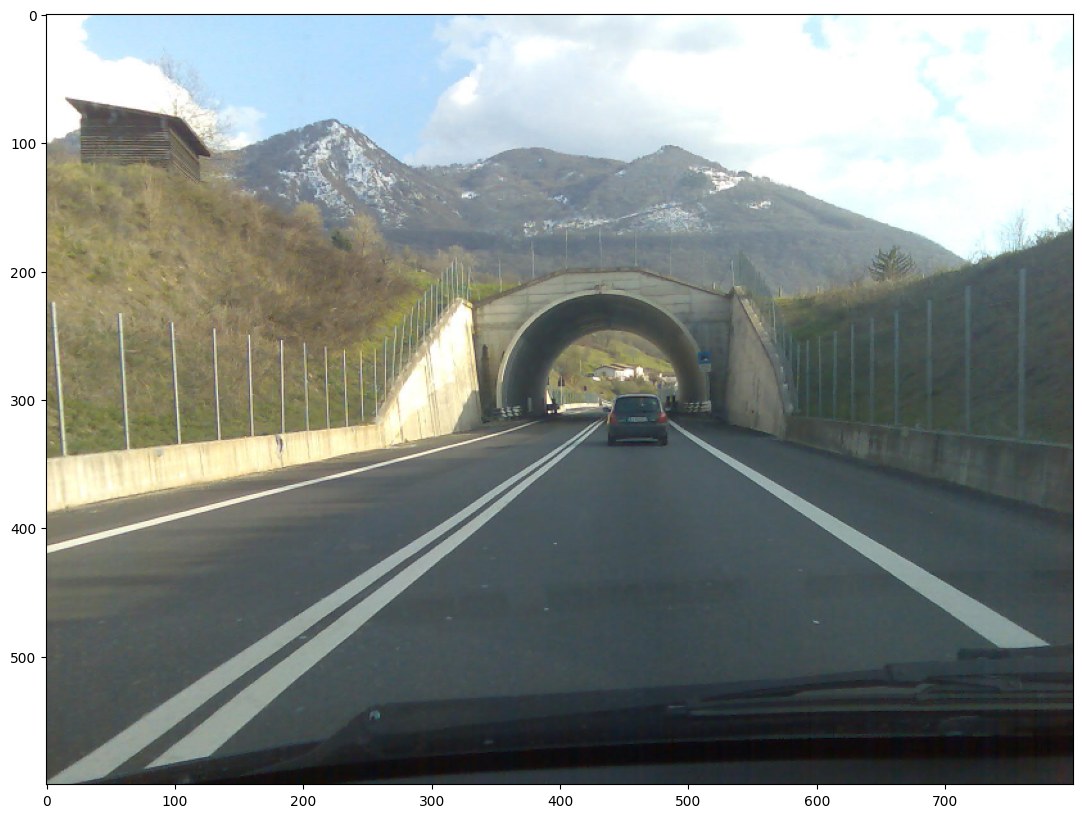

In [2]:
img = cv2.imread('../data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [11]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [12]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:300] = 0

(<AxesSubplot: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

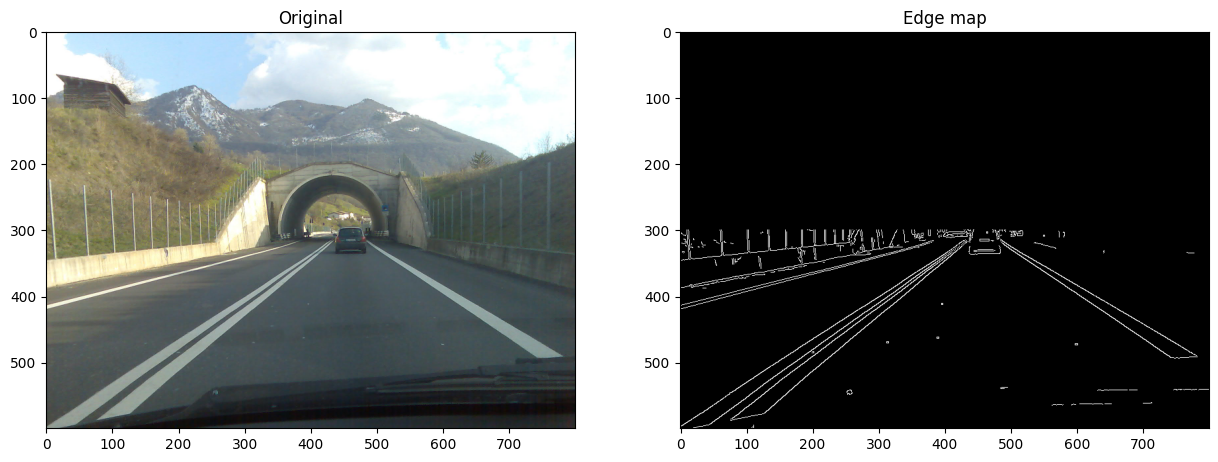

In [5]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [13]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLines(edges, rho=1, theta=2*np.pi/180, threshold=140)
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

(<AxesSubplot: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

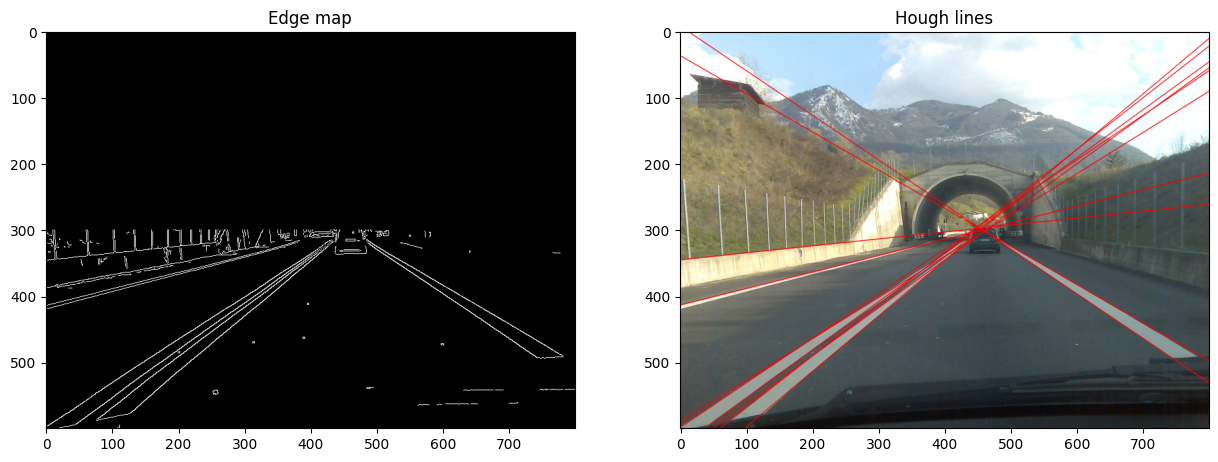

In [14]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [15]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[1] * (180/np.pi)
    # Keep line if theta is not horizontal
    if not (70 < theta < 110):
        filtered_lines.append(line)

(<AxesSubplot: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

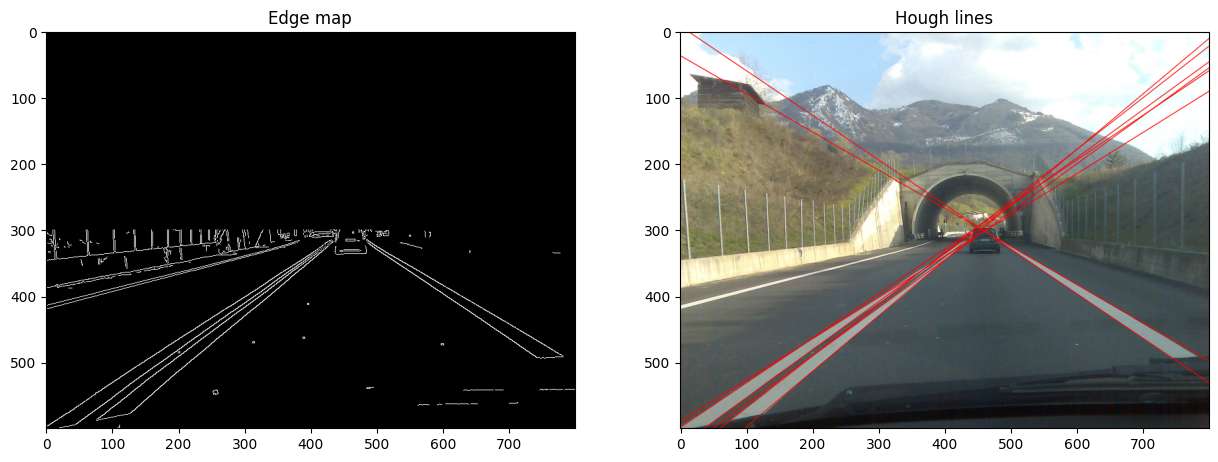

In [16]:
# Let's plot the resulting filtered lines
result = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [17]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

W:\workspace\dev\py\Computer-Vision-v2\cv-course\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[498.        ,   0.99483767],
       [ 32.        ,   2.09439516],
       [ -7.        ,   2.16420817],
       [508.5       ,   0.92502448],
       [522.        ,   0.87266463],
       [514.        ,   0.94247776]])

(<AxesSubplot: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

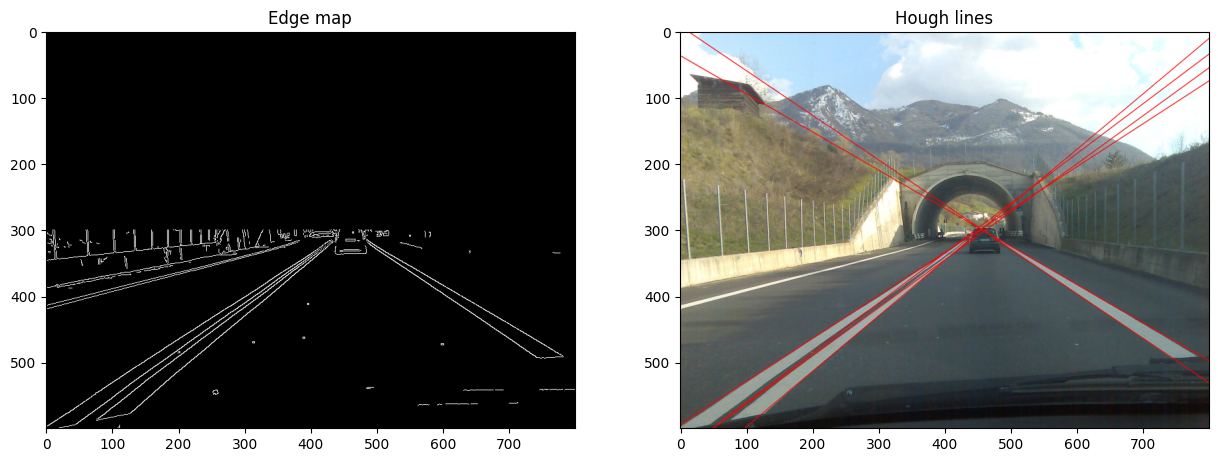

In [18]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

### Questions
* Do you see anything strange in the final result? - Not really, but I had to modify some of predefined lines of code in order to get enough Hough lines to apply K-means clustering. Before that the result already looked pretty good.
* Do you think the Hough transform resolution is important for obtaining a good result? Why? - This value is important in order to avoid rudandant classifing or skipping of important lines. 
* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why? - This parameter lets us filter unimportant lines caused by noise in image, it comes to be especially handy in cases when we know average(expected) length of important lines. (e.g. traffic lines)